In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as seabornInstance
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn import metrics
from sklearn.linear_model import LassoCV

import random
import time
import pickle
import sys

In [11]:
dataset = pd.read_csv('processed_data.csv')
print(dataset.columns)

Index(['user_id', 'age', 'male', 'female', 'Drama', 'Comedy', 'Family',
       'Fantasy', 'Romance', 'Music', 'Documentary', 'Horror', 'History',
       'TV Movie', 'Foreign', 'Crime', 'Thriller', 'Mystery', 'Action',
       'Western', 'Adventure', 'War', 'Science Fiction', 'Animation', 'rate'],
      dtype='object')


In [12]:
X = dataset.drop(['user_id','rate'],axis=1).values
y = dataset['rate']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
clf = Lasso(alpha=1.0)
clf.fit(X, y)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Calculate accuracy of linear regression lasso
parameters = {'alpha':np.arange(0.001,0.05,0.0001)}
linear_model = Lasso()
clf = GridSearchCV(linear_model, parameters, cv=5, scoring='neg_mean_squared_error')
clf.fit(X_train, y_train)
print(clf.best_params_, clf.best_score_)
print("The MSE of linear regression is: %f"%(-clf.best_score_))

{'alpha': 0.001} -0.5338245530324598
The MSE of linear regression is: 0.533825


In [14]:
# Calculate accuracy of random forest regression
parameters = {'max_depth':range(1,10),'n_estimators':range(1,10)}
clf = GridSearchCV(RandomForestRegressor(), parameters, cv=5, scoring='neg_mean_squared_error')
clf.fit(X_train, y_train.ravel())
print(clf.best_params_, clf.best_score_)
print("The MSE of random forest regression is: %f"%(-clf.best_score_))

{'max_depth': 6, 'n_estimators': 8} -0.5333903968881544
The MSE of random forest regression is: 0.533390


In [17]:
def generate_fake_data(X, axis_num, ratio):
    res = np.concatenate((X, X), axis=axis_num)
    for i in range(ratio):
        res = np.concatenate((res, res), axis=axis_num)
    return res

In [18]:
def evaluation(iteration, model1, model2, orginal_X, original_Y, axis_num):
    # model size
    m1_model_size, m2_model_size = [], []
    # training time
    m1_training_time, m2_training_time = [], []
    # inference time
    m1_inference_time, m2_inference_time = [], []
    # sample number
    sample_num = []
    # feature num
    feature_num = []
    
    for i in range(iteration):
        print("the %d iteration"%i)
        X_large_sample_num = generate_fake_data(orginal_X,axis_num,ratio=i)
        if axis_num == 0:
            y_large_sample_num = generate_fake_data(original_Y,axis_num,ratio=i)
        else:
            y_large_sample_num = original_Y
        sample_num.append(X_large_sample_num.shape[0])
        feature_num.append(X_large_sample_num.shape[1])
        
        print(X_large_sample_num.shape, y_large_sample_num.shape)
        start_time = time.time()
        model1.fit(X_large_sample_num,y_large_sample_num)
        end_time = time.time()
        m1_training_time.append(end_time - start_time)
        p = pickle.dumps(model1)
        m1_model_size.append(sys.getsizeof(p))
        start_time = time.time()
        model1.predict(X_large_sample_num)
        end_time = time.time()
        m1_inference_time.append(end_time - start_time)

        y_large_sample_num = y_large_sample_num.ravel()
        start_time = time.time()
        model2.fit(X_large_sample_num,y_large_sample_num)
        end_time = time.time()
        m2_training_time.append(end_time - start_time)
        p = pickle.dumps(model2)
        m2_model_size.append(sys.getsizeof(p))
        start_time = time.time()
        model2.predict(X_large_sample_num)
        end_time = time.time()
        m2_inference_time.append(end_time - start_time)
        
    m1_name, m2_name = 'Linear Regression Lasso', 'Random Forest Regression'
    if axis_num==1:
        fig = plt.figure()
        ax = plt.subplot(111)
        ax.plot(feature_num,m1_training_time,label=m1_name)
        ax.plot(feature_num,m2_training_time,label=m2_name)
        ax.legend()
        plt.xlabel('feature_num', fontsize=18)
        plt.ylabel('training_time / seconds', fontsize=18)
        plt.show()

        fig = plt.figure()
        ax = plt.subplot(111)
        ax.plot(feature_num,m1_model_size,label=m1_name)
        ax.plot(feature_num,m2_model_size,label=m2_name)
        ax.legend()
        plt.xlabel('feature_num', fontsize=18)
        plt.ylabel('model_size / bytes', fontsize=18)
        plt.show()
        
        fig = plt.figure()
        ax = plt.subplot(111)
        ax.plot(feature_num,m1_inference_time,label=m1_name)
        ax.plot(feature_num,m2_inference_time,label=m2_name)
        ax.legend()
        plt.xlabel('feature_num', fontsize=18)
        plt.ylabel('inference_time / seconds', fontsize=18)
        plt.show()
    else:
        fig = plt.figure()
        ax = plt.subplot(111)
        ax.plot(sample_num,m1_training_time,label=m1_name)
        ax.plot(sample_num,m2_training_time,label=m2_name)
        ax.legend()
        plt.xlabel('sample_num', fontsize=18)
        plt.ylabel('training_time / seconds', fontsize=18)
        plt.show()

        fig = plt.figure()
        ax = plt.subplot(111)
        ax.plot(sample_num,m1_model_size,label=m1_name)
        ax.plot(sample_num,m2_model_size,label=m2_name)
        ax.legend()
        plt.xlabel('sample_num', fontsize=18)
        plt.ylabel('model_size / bytes', fontsize=18)
        plt.show()

        fig = plt.figure()
        ax = plt.subplot(111)
        ax.plot(sample_num,m1_inference_time,label=m1_name)
        ax.plot(sample_num,m2_inference_time,label=m2_name)
        ax.legend()
        plt.xlabel('sample_num', fontsize=18)
        plt.ylabel('inference_time / bytes', fontsize=18)        
        plt.show()
        
    return (m1_model_size, m2_model_size, m1_training_time, m2_training_time, 
            m1_inference_time, m2_inference_time, sample_num, feature_num)

the 0 iteration
(25068, 23) (25068,)
the 1 iteration
(50136, 23) (50136,)
the 2 iteration
(100272, 23) (100272,)
the 3 iteration
(200544, 23) (200544,)
the 4 iteration
(401088, 23) (401088,)
the 5 iteration
(802176, 23) (802176,)


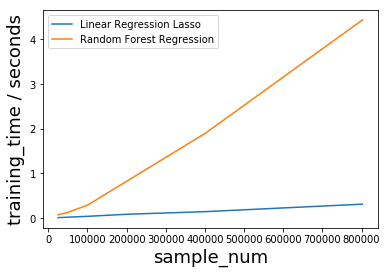

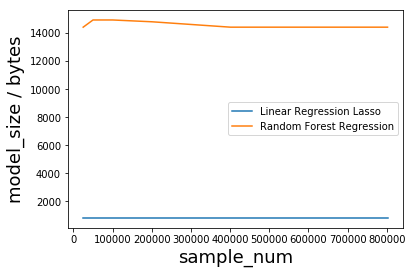

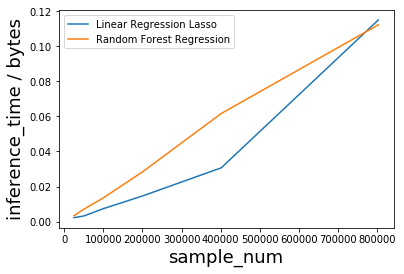

In [20]:
model1, model2 = Lasso(alpha=0.1), RandomForestRegressor(max_depth=4, n_estimators=7)

(m1_model_size, m2_model_size, m1_training_time, m2_training_time, 
m1_inference_time, m2_inference_time, sample_num, feature_num)= evaluation(6, model1, model2, X, y, 0)

the 0 iteration
(12534, 46) (12534,)
the 1 iteration
(12534, 92) (12534,)
the 2 iteration
(12534, 184) (12534,)
the 3 iteration
(12534, 368) (12534,)
the 4 iteration
(12534, 736) (12534,)
the 5 iteration
(12534, 1472) (12534,)


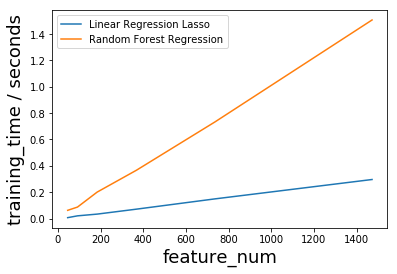

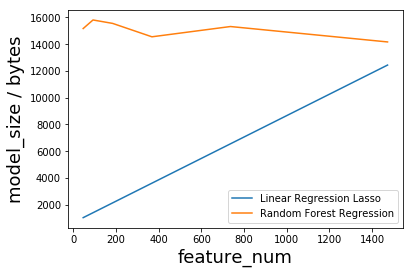

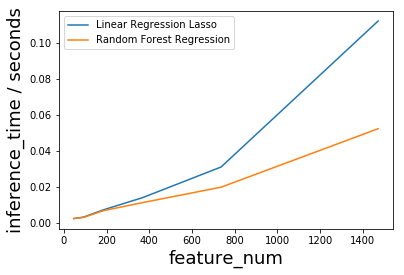

In [21]:
(m1_model_size, m2_model_size, m1_training_time, m2_training_time, 
m1_inference_time, m2_inference_time, sample_num, feature_num) = evaluation(6, model1, model2, X, y, 1)